In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import add_constant
from ISLP import load_data
from ISLP import confusion_table
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer

In [7]:
stock_market_data = load_data("Smarket")
print(stock_market_data.shape)
stock_market_data

(1250, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


## LASSO逻辑回归与交叉验证

LASSO（最小绝对收缩和选择算子）逻辑回归是一种强大的正则化技术，通过对系数大小施加惩罚来防止逻辑回归模型的过拟合。此惩罚项促使模型将部分系数缩减为零，从而实现特征选择。因此，当处理高维数据或希望识别最重要的预测变量时，LASSO 尤为有用。

**交叉验证** 是一种模型验证技术，通过将数据分为多个folds（折），在数据的子集上训练模型，并在剩余子集上验证它来评估模型性能。结合LASSO，交叉验证可以优化正则化强度（`C`，相当于线性回归交叉验证中的 `alpha`，或课程笔记中的 `lambda`），决定对系数施加的惩罚力度。通过交叉验证，我们可以选择使目标性能指标（如ROC曲线下面积AUC）最大的正则化参数。AUC衡量模型区分正负类的能力。

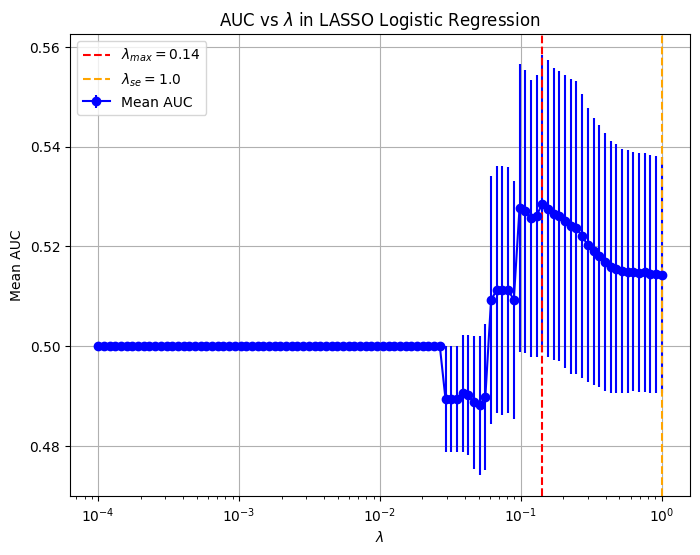

In [8]:
x = stock_market_data.drop(columns=["Today", "Direction", "Year"])
y = stock_market_data.Direction == "Up"

lambdas = np.logspace(-4, 0, 100)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)


cv_folds = 5
lasso_cv = LogisticRegressionCV(
    Cs=lambdas,  # Number of inverse regularisation strength values to test (same as `lambda` in the lecture notes)
    cv=cv_folds,  # 5-fold cross-validation
    penalty="l1",  # LASSO (L1 regularisation)
    solver="saga",  # Solver that supports L1 regularisation
    scoring="roc_auc",  # Optimise for AUC
    max_iter=10000,  # Allow for sufficient iterations for convergence
    random_state=0,
)

lasso_cv.fit(x_train, y_train)

lambdas = lasso_cv.Cs_
mean_auc_scores = np.mean(lasso_cv.scores_[1], axis=0)
se_auc_scores = np.std(lasso_cv.scores_[1], axis=0) / np.sqrt(cv_folds - 1)

plt.figure(figsize=(8, 6))
plt.errorbar(
    lambdas,
    mean_auc_scores,
    yerr=se_auc_scores,
    marker="o",
    color="blue",
    label="Mean AUC",
)
plt.xscale("log")  # Use log scale for C values (since C spans several magnitudes)
plt.xlabel(r"$\lambda$")
plt.ylabel("Mean AUC")
plt.title(r"AUC vs $\lambda$ in LASSO Logistic Regression")
plt.grid(True)

max_auc_index = np.argmax(mean_auc_scores)
max_auc = mean_auc_scores[max_auc_index]
max_lambda = lambdas[max_auc_index]
one_se_threshold = max_auc - se_auc_scores[max_auc_index]

one_se_index = np.where(mean_auc_scores >= one_se_threshold)[0][-1]
one_se_lambda = lambdas[one_se_index]

plt.axvline(
    x=max_lambda,
    color="r",
    linestyle="--",
    label=rf"$\lambda_{{max}}={{{max_lambda:0.2}}}$",
)
plt.axvline(
    x=one_se_lambda,
    color="orange",
    linestyle="--",
    label=rf"$\lambda_{{se}}={{{one_se_lambda:.2}}}$",
)
plt.legend(loc="best")
plt.show()

In [9]:
x_test = x_test[["Lag1", "Lag2"]]
x_test = add_constant(x_test)

x_train = x_train[["Lag1", "Lag2"]]
x_train = add_constant(x_train)
test_len = len(x_test)

labels_test = np.array(["Down"] * test_len)
labels_test[y_test == True] = "Up"

glm_train = sm.GLM(y_train, x_train, family=sm.families.Binomial())
results = glm_train.fit()
print(results.params)
probs_test = results.predict(exog=x_test)

labels_pred = np.array(["Down"] * test_len)
labels_pred[probs_test > 0.5] = "Up"
confusion_table(labels_pred, labels_test)

const    0.128718
Lag1    -0.098394
Lag2    -0.085848
dtype: float64


Truth,Down,Up
Predicted,,
Down,31,23
Up,160,161


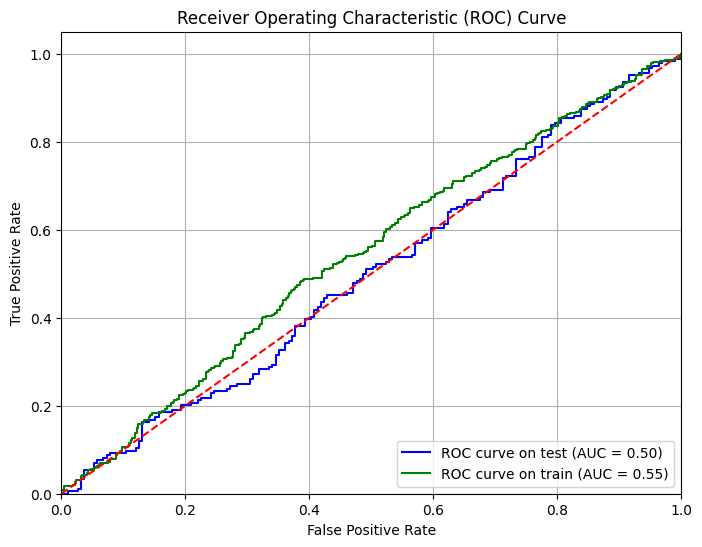

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr, tpr, thresholds = roc_curve(y_test, probs_test)
auc_test = roc_auc_score(y_test, probs_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve on test (AUC = {auc_test:.2f})")

probs_train = results.predict(exog=x_train)
fpr, tpr, thresholds = roc_curve(y_train, probs_train)
auc_train = roc_auc_score(y_train, probs_train)
plt.plot(fpr, tpr, color="green", label=f"ROC curve on train (AUC = {auc_train:.2f})")


plt.plot(
    [0, 1], [0, 1], color="red", linestyle="--"
)  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()